<h2>Policy evaluation with MC</h2>

Rather than bootstrapping for eps, use MC methods

In [242]:
import gym
import numpy as np
import pandas as pd
import matplotlib
%matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict

Using matplotlib backend: nbAgg


In [2]:
import Box2D
env = gym.make('Blackjack-v0')#.env
rand_pol = np.random.randint(0,6,1000)
obs= env.reset()
#env.render()

Blackjack rules and scoring:
    - first to make 21
    - Reward for stick:
        - +1 if sum of cards > sum of dealer cards 0 if sum of cards = sum of dealer cards -1 if sum of cards < sum of dealer cards
        - Reward for twist:
        - -1 if sum of cards > 21 (and terminate)
        - 0 otherwise

In [3]:
print(env.action_space)
print(env.observation_space)

Discrete(2)
Tuple(Discrete(32), Discrete(11), Discrete(2))


In [442]:
def policy(score):
    if score <=12:
        return 1
    elif score >=20:
        return 0
    else:
        r = np.random.randint(1,10)
        if r<=5:
            return 0
        else:
            return 1

def every_visit_mc(env, n_eps=1000000):
    all_visits={}
    count_visits={}
    returns ={}
    Q = defaultdict(lambda : np.zeros(env.action_space.n))g
    #generate episode 
    for ep in range(n_eps):
        list_ep=[]

        observation =env.reset()
        
        for t in range(100):
            
            score, dealer_score, ace = observation
            action = policy(score)
            next_state, rew, done, info = env.step(action)
            list_ep.append([observation, action, rew])
            
            if done:
                break
                
            observation=next_state
                
        for (observation, action, reward) in list_ep:
            if not (observation, action) in count_visits.keys():
                    count_visits[(observation, action)]=1.0
            else:
                    count_visits[(observation, action)]+=1.0
            Q[observation][action] += reward / count_visits[(observation, action)]
        
    return Q
    
Q_MC_eval = every_visit_mc(env)

#print(pd.DataFrame.from_dict(sorted(V.items(), key= lambda x:x)))



In [443]:
print(len(V), len(V_MC))
min(Q_MC_eval.items())
V_MC

440 280


{(4, 1, False): 0.0,
 (4, 2, False): 0.0,
 (4, 3, False): 0.0,
 (4, 4, False): 0.0,
 (4, 5, False): 0.0,
 (4, 6, False): 0.0,
 (4, 7, False): 0.0,
 (4, 8, False): 0.0,
 (4, 9, False): 0.0,
 (4, 10, False): 0.0,
 (5, 1, False): 0.0,
 (5, 2, False): 0.0,
 (5, 3, False): 0.0,
 (5, 4, False): 0.0,
 (5, 5, False): 0.0,
 (5, 6, False): 0.0,
 (5, 7, False): 0.0,
 (5, 8, False): 0.0,
 (5, 9, False): 0.0,
 (5, 10, False): 0.0,
 (6, 1, False): 0.0,
 (6, 2, False): 0.0,
 (6, 3, False): 0.0,
 (6, 4, False): 0.0,
 (6, 5, False): 0.0,
 (6, 6, False): 0.0,
 (6, 7, False): 0.0,
 (6, 8, False): 0.0,
 (6, 9, False): 0.0,
 (6, 10, False): 0.0,
 (7, 1, False): 0.0,
 (7, 2, False): 0.0,
 (7, 3, False): 0.0,
 (7, 4, False): 0.0,
 (7, 5, False): 0.0,
 (7, 6, False): 0.0,
 (7, 7, False): 0.0,
 (7, 8, False): 0.0,
 (7, 9, False): 0.0,
 (7, 10, False): 0.0,
 (8, 1, False): 0.0,
 (8, 2, False): 0.0,
 (8, 3, False): 0.0,
 (8, 4, False): 0.0,
 (8, 5, False): 0.0,
 (8, 6, False): 0.0,
 (8, 7, False): 0.0,
 (8, 8, F

NameError: name 'list_ep' is not defined

<IPython.core.display.Javascript object>


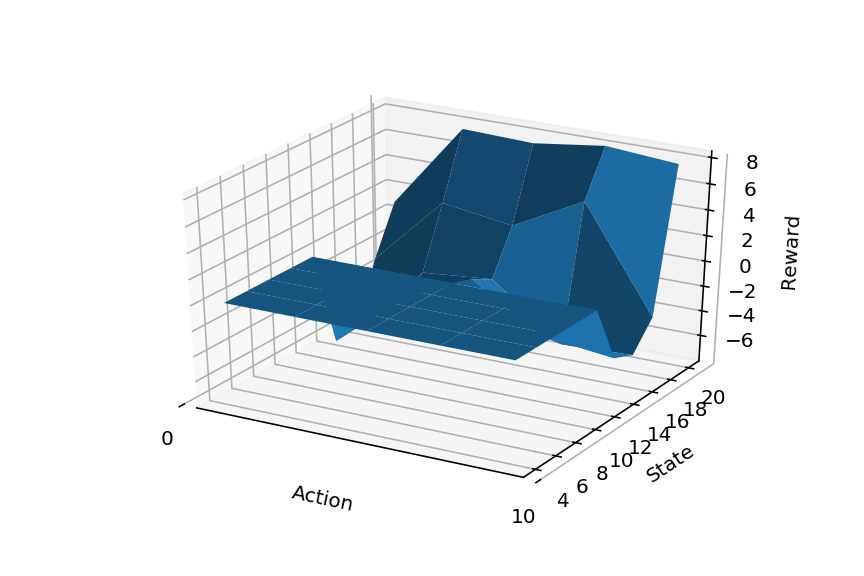

In [441]:
#Vals in dict are (rew for doing action 0, rew for doing action 1)
#Assuming a totally greedy policy we would always choose the higher one 
def plot_surface(Q):
    V_MC = {}
    for state, vs in Q.items():
        act = np.argmax(vs)
        val =np.max(vs)
        V_MC[state] = val


    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')


    #x=[state[0] for (state, rew) in Qu.items() ]
    #y=[np.argmax(rew) for (state, rew) in Qu.items()]
    #z=[np.max(rew) for (state, rew) in Qu.items() ]
    x_vals = np.arange(min([k[0] for k in Q.keys()]),
                       max([k[0] for k in Q.keys()])+1,
                       2)
    y_vals = np.arange(min([k[1] for k in Q.keys()]),
                       max([k[1] for k in Q.keys()])+1,
                       2)

    X,Y = np.meshgrid(x_vals,y_vals)
    Z=np.apply_along_axis(lambda _: Q[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    #Z,_ = np.meshgrid(z,z)

    ax.set_xticks(np.arange(0,10,9.9999999))
    ax.set_ylabel('State')
    ax.set_xlabel('Action')
    ax.set_zlabel('Reward')
    #ax.scatter(y,x,z)

    ax.plot_surface(Y,X,Z[:,:,0])
    return

plot_surface(Q_MC_eval)

<h2>On-policy Monte Carlo control</h2>

In [266]:
def eps_greedy_policy(state, returns):
    opt_act = np.argmax(returns[state])
    return opt_act

def policy(state, returns):
    eps = 0.75
    opt_act = np.argmax(returns[state])
    worse_act = np.argmin(returns[state])
    r= np.random.choice([0,1],1,p=[1.0-eps+(eps/2.0), eps/2.0]).astype(str)[0]
    if r=='1':
        return opt_act
    else:
        return worse_act #If >2 actions, we would pick a random one
    return act 
        
            
def every_visit_mc(env, n_eps=100000):
    all_returns={}
    count_visits={}
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    for ep in range(n_eps):
        
        list_ep=[]
        G=0
        observation =env.reset()
        
        for t in range(10000):
            score, dealer_score, ace = observation
            action=policy(observation, Q)
            next_state, rew, done, info = env.step(action)   
            G+=rew #need to discount
         
            list_ep.append([observation, action, G])

            if done:
                break
            observation=next_state
        
    
        for (observation, action, reward) in list_ep:
            if not (observation, action) in count_visits.keys():
                    count_visits[(observation, action)]=1.0
            else:
                    count_visits[(observation, action)]+=1.0
            Q[observation][action] += reward / count_visits[(observation, action)]


    return Q
    
Qu = every_visit_mc(env)

#print(pd.DataFrame.from_dict(sorted(V.items(), key= lambda x:x)))

In [237]:
Qu

defaultdict(<function __main__.every_visit_mc.<locals>.<lambda>>,
            {(4, 1, False): array([-3.81350914,  0.        ]),
             (4, 2, False): array([-1.33191056,  0.        ]),
             (4, 3, False): array([-2.67240681,  0.        ]),
             (4, 4, False): array([-2.40479226,  0.        ]),
             (4, 5, False): array([-2.20437447,  0.        ]),
             (4, 6, False): array([-2.3015742,  0.       ]),
             (4, 7, False): array([-2.16178087,  0.        ]),
             (4, 8, False): array([-1.71254862,  0.        ]),
             (4, 9, False): array([-2.84283831,  0.        ]),
             (4, 10, False): array([-2.58084886,  0.        ]),
             (5, 1, False): array([-4.21767173,  0.        ]),
             (5, 2, False): array([1.52832351, 0.        ]),
             (5, 3, False): array([-0.80828438,  0.        ]),
             (5, 4, False): array([-0.72555613,  0.        ]),
             (5, 5, False): array([1.2412615, 0.       

<IPython.core.display.Javascript object>


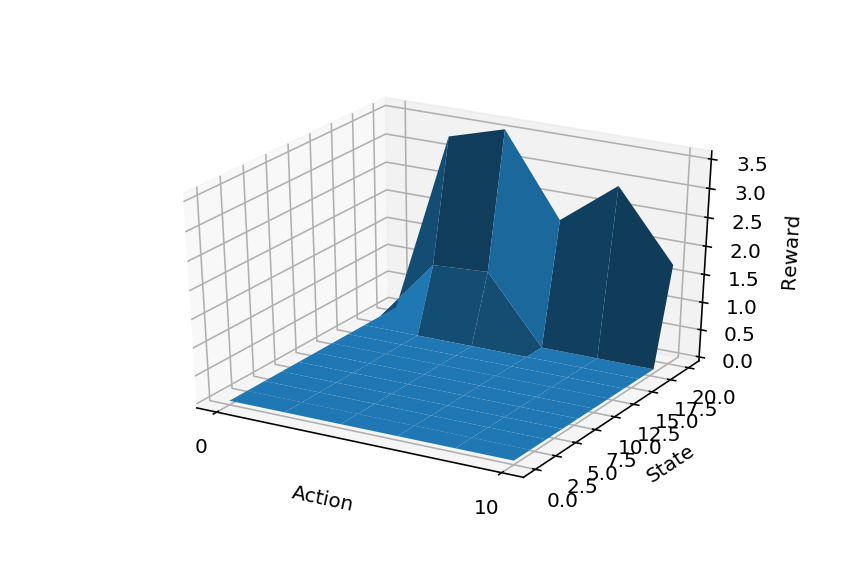

In [414]:
plot_surface(Qu)